# Previsão de demanda energética

Previsão de 1 horas na frente utilizando apenas uma rede utilizando hora e dia como entradas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import seaborn as sb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

C:\Users\Pedro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Carregar dataset residencial

In [2]:
casas = {}
for i, filePath in enumerate(sorted(glob.glob('Corporativo/*.csv'))):
    casas[i] = pd.read_csv(filePath).filter(['date', 'activeEnergy', 'cepa', 'cepb', 'cepc'])
    #casas[i] = casas[i].dropna(axis = 'columns', how = 'all')
    casas[i]['date'] = pd.to_datetime(casas[i]['date'], yearfirst=True, dayfirst= True, errors = 'coerce')
    casas[i]['weekDay'] = casas[i]['date'].dt.weekday
    casas[i]['hours'] = casas[i]['date'].dt.hour
    casas[i]['EnergyNextHour'] = casas[i]['activeEnergy'].shift(-1)
    casas[i]['EnergyNext2Hours'] = casas[i]['activeEnergy'].shift(-2)
    casas[i].drop(casas[i].index[-3:], inplace = True)
    #casas[i].dropna(axis = 0, how = 'any', inplace = True)
    
    #casas[i] = casas[i][casas[i]['activeEnergy'] < 4*casas[i]['activeEnergy'].std()]

In [3]:
a = 7

In [4]:
print(pd.isnull(casas[a]).any())
#df.loc[df['column_name'] == some_value]

casas[a].head()

date                False
activeEnergy        False
cepa                False
cepb                False
cepc                False
weekDay             False
hours               False
EnergyNextHour      False
EnergyNext2Hours    False
dtype: bool


,date,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
0,2017-03-01 00:00:00,9736,2696,5273,1767,2,0,11733.0,9170.0
1,2017-03-01 01:00:00,11733,3608,6011,2114,2,1,9170.0,11795.0
2,2017-03-01 02:00:00,9170,2498,5094,1578,2,2,11795.0,9227.0
3,2017-03-01 03:00:00,11795,3525,6087,2183,2,3,9227.0,8965.0
4,2017-03-01 04:00:00,9227,2532,5151,1544,2,4,8965.0,9402.0


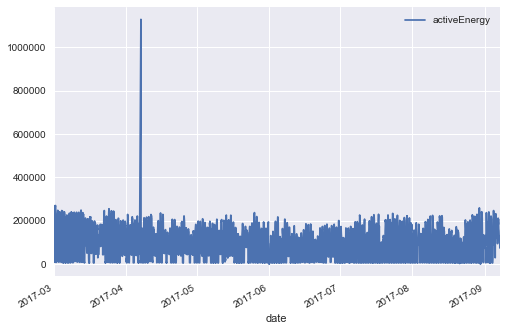

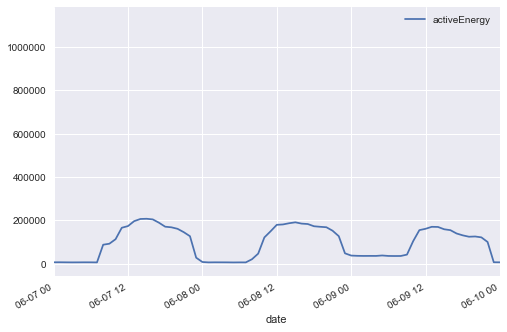

In [5]:
casas[a].plot(x = 'date', y = ['activeEnergy'])#, xlim = ['2017-03-01 00:00:00', ['2017-03-02 00:00:00']])
plt.show()
casas[a].plot(x = 'date', y = ['activeEnergy'], xlim = ['2017-06-07 00:00:00', ['2017-06-10 00:00:00']])
plt.show()

## Truncar os dados

In [6]:
train_set = casas[a][casas[a]['date'] < '2017-08-15 00:00:00']
test_set = casas[a][casas[a]['date'] > '2017-08-15 00:00:00']#.reset_index()

## Retirar tendência

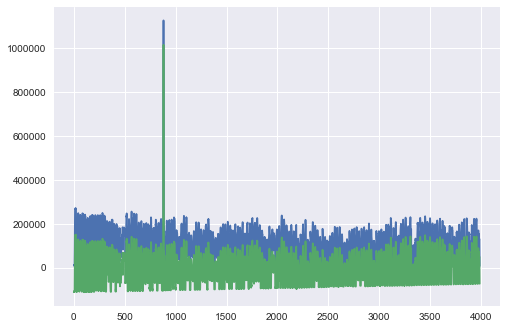

In [7]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
#print(train_set.index.shape, train_set['activeEnergy'].shape)
linearReg.fit(train_set.index[:, np.newaxis], train_set['activeEnergy'])
train_set_without_tendency = train_set['activeEnergy'] - linearReg.predict(train_set.index[:, np.newaxis])
plt.plot(train_set['activeEnergy'])
plt.plot(train_set_without_tendency)
plt.show()

In [8]:
F = train_set.set_index('date')
#print(F.index.freq)
s = sm.tsa.seasonal_decompose(F.activeEnergy, freq = 24)

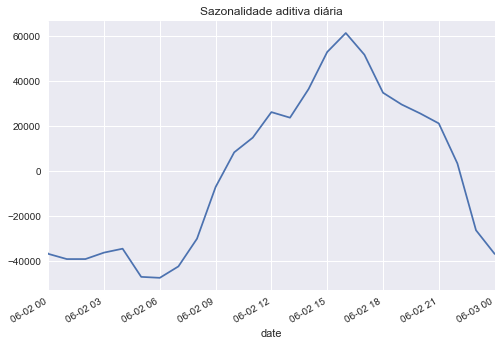

In [9]:
s.seasonal.plot(xlim = ['2017-06-02', '2017-06-03'])
plt.title('Sazonalidade aditiva diária')
plt.show()

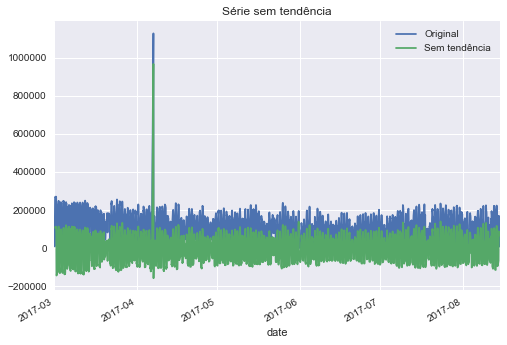

In [10]:
train_set_without_tendency = train_set.set_index('date')['activeEnergy'] - s.trend
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_tendency.plot()
plt.title('Série sem tendência')
plt.legend(['Original', 'Sem tendência'])
plt.show()

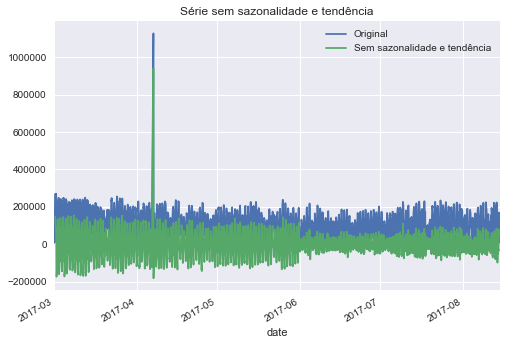

In [11]:
train_set_without_season = train_set_without_tendency - s.seasonal
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_season.plot()
plt.legend(['Original', 'Sem sazonalidade e tendência'])
plt.title('Série sem sazonalidade e tendência')
plt.show()


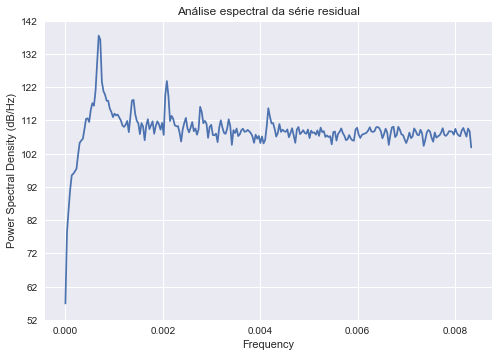

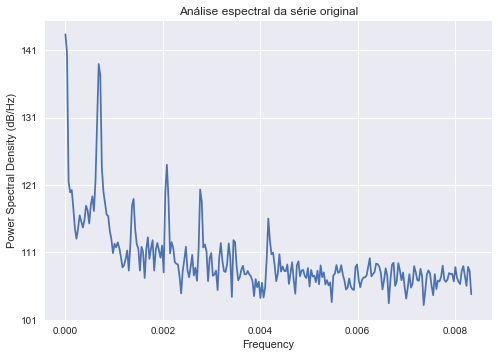

In [12]:
plt.psd(s.resid.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série residual')
plt.show()
plt.psd(F.activeEnergy.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série original')
plt.show()

In [13]:
train_set.set_index('date', inplace = True)
train_set['ResidualSeries'] = s.resid
train_set['SeasonalSeries'] = s.seasonal
train_set['TrendSeries'] = s.trend
train_set.dropna(axis = 0, how = 'any', inplace = True)
train_set.head()

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-03-01 12:00:00,264522,103033,81091,80398,2,12,269691.0,268806.0,148380.731135,-42582.543635,158723.812500
2017-03-01 13:00:00,269691,104390,83328,81973,2,13,268806.0,269172.0,141284.887762,-30251.012762,158657.125000
2017-03-01 14:00:00,268806,104084,82742,81980,2,14,269172.0,268889.0,117478.757993,-7269.382993,158596.625000
2017-03-01 15:00:00,269172,104314,83109,81749,2,15,268889.0,266366.0,102418.264142,8161.506691,158592.229167
2017-03-01 16:00:00,268889,104574,82828,81487,2,16,266366.0,270185.0,95484.629353,14706.578980,158697.791667


In [14]:
test_set.set_index('date', inplace = True)
test_set = test_set[:'2017-08-26']
print(test_set.index.freq)
test_set.tail()

None


,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
date,,,,,,,,
2017-08-26 19:00:00,213210,82948,66259,64003,5,19,197262.0,176474.0
2017-08-26 20:00:00,197262,77490,61216,58556,5,20,176474.0,89095.0
2017-08-26 21:00:00,176474,68821,56236,51417,5,21,89095.0,7201.0
2017-08-26 22:00:00,89095,34215,32323,22557,5,22,7201.0,6786.0
2017-08-26 23:00:00,7201,2387,3906,908,5,23,6786.0,6917.0


In [15]:
#test_set.set_index('date', inplace = True)
F = test_set.activeEnergy
sTest = sm.tsa.seasonal_decompose(F, freq = 24)
test_set['ResidualSeries'] = sTest.resid
test_set['SeasonalSeries'] = sTest.seasonal
test_set['TrendSeries'] = sTest.trend
test_set.dropna(axis = 0, how = 'any', inplace = True)
test_set.head()

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-08-15 13:00:00,126788,51361,42453,32974,1,13,123750.0,127227.0,-8045.765057,65043.660890,69790.104167
2017-08-15 14:00:00,123750,50479,41509,31762,1,14,127227.0,135893.0,-13774.848390,67724.806723,69800.041667
2017-08-15 15:00:00,127227,51992,42491,32744,1,15,135893.0,123202.0,-9623.969602,67029.344602,69821.625000
2017-08-15 16:00:00,135893,54055,46970,34868,1,16,123202.0,118356.0,-891.071875,66942.176042,69841.895833
2017-08-15 17:00:00,123202,47691,44351,31160,1,17,118356.0,120556.0,-9493.835133,62830.897633,69864.937500


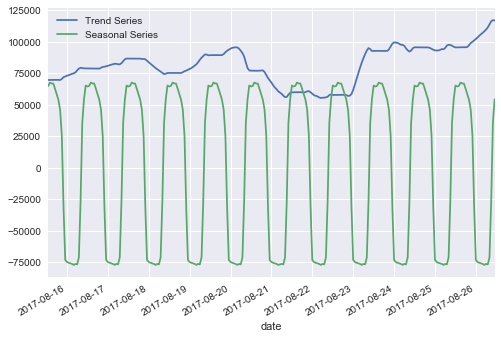

In [16]:
test_set.TrendSeries.plot()
test_set.SeasonalSeries.plot()
plt.legend(['Trend Series', 'Seasonal Series'])
plt.show()

## Pré processamento dos dados

In [17]:
matrix =  casas[a].as_matrix(columns = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 
                                        'hours', 'EnergyNextHour', 'EnergyNext2Hours']).T
print(matrix.shape)
correlationCoef = np.corrcoef(matrix[:,3:])

(8, 4550)


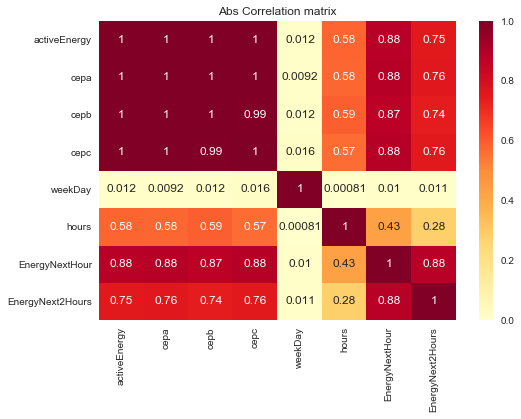

In [18]:
sb.heatmap(np.abs(correlationCoef),
           annot=True, cmap = 'YlOrRd', vmin = 0, vmax =  1,
          xticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'],
          yticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'])
plt.title('Abs Correlation matrix')
plt.show()

## Regressão com Multilayer Perceptron

In [19]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


Além do look_back, o create_dataset no Teste2 adiciona a hora e a data dos dados

In [20]:
def create_dataset(dataset, hour, weekday, look_back=1, look_forward = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward-1):
        a = dataset[i:(i+look_back)]
        a = np.hstack((a, np.sin((2*np.pi/24)*hour[i]), np.sin((2*np.pi/7)*weekday[i])))
        dataX.append(a)
        
        b = dataset[i + look_back:i + look_back + look_forward]
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

In [21]:
train_set.shape
look_forward = 1
look_back = 1
#create_dataset(train_series, look_back = 6)

In [22]:
#len(train_set['ResidualSeries'].values)
train_values = train_set['ResidualSeries'].values
train_mean = train_set['ResidualSeries'].mean()
train_std = train_set['ResidualSeries'].std()
train_values -= train_mean
train_values /= train_std


test_values = test_set['ResidualSeries'].values
test_mean = test_set['ResidualSeries'].mean()
test_std = test_set['ResidualSeries'].std()
test_values -= test_mean
test_values /= test_std

x, y = create_dataset(train_values,
                      hour = train_set['hours'].values, 
                      weekday = train_set['weekDay'].values, 
                      look_back = look_back, 
                      look_forward = look_forward)
testx, testy = create_dataset(test_values, 
                              hour = test_set['hours'].values,
                              weekday = test_set['weekDay'].values,
                              look_back = look_back, 
                              look_forward = look_forward)

print(y[:10], '\n',train_values[:10])
print(y.shape, x.shape)

[[ 2.10390982]
 [ 1.74921425]
 [ 1.52482287]
 [ 1.4215163 ]
 [ 1.2119802 ]
 [ 1.30456128]
 [ 1.1135986 ]
 [ 0.8925376 ]
 [ 0.74774274]
 [ 0.36377563]] 
 [ 2.20963319  2.10390982  1.74921425  1.52482287  1.4215163   1.2119802
  1.30456128  1.1135986   0.8925376   0.74774274]
(3962, 1) (3962, 3)


In [23]:
model = Sequential()
model.add(Dense(32, input_dim = look_back + 2, activation = 'relu')) # 2 devido a hora e weekday
model.add(Dense(look_forward))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [24]:
history = model.fit(x, y, epochs = 500, validation_split = 0.2, batch_size = 41, verbose =  2)

Train on 3169 samples, validate on 793 samples
Epoch 1/500
0s - loss: 0.8498 - val_loss: 0.1882
Epoch 2/500
0s - loss: 0.3550 - val_loss: 0.1415
Epoch 3/500
0s - loss: 0.3021 - val_loss: 0.1280
Epoch 4/500
0s - loss: 0.2912 - val_loss: 0.1264
Epoch 5/500
0s - loss: 0.2882 - val_loss: 0.1255
Epoch 6/500
0s - loss: 0.2857 - val_loss: 0.1250
Epoch 7/500
0s - loss: 0.2832 - val_loss: 0.1259
Epoch 8/500
0s - loss: 0.2825 - val_loss: 0.1243
Epoch 9/500
0s - loss: 0.2800 - val_loss: 0.1248
Epoch 10/500
0s - loss: 0.2779 - val_loss: 0.1276
Epoch 11/500
0s - loss: 0.2774 - val_loss: 0.1245
Epoch 12/500
0s - loss: 0.2756 - val_loss: 0.1238
Epoch 13/500
0s - loss: 0.2738 - val_loss: 0.1252
Epoch 14/500
0s - loss: 0.2727 - val_loss: 0.1251
Epoch 15/500
0s - loss: 0.2705 - val_loss: 0.1260
Epoch 16/500
0s - loss: 0.2697 - val_loss: 0.1260
Epoch 17/500
0s - loss: 0.2681 - val_loss: 0.1250
Epoch 18/500
0s - loss: 0.2673 - val_loss: 0.1250
Epoch 19/500
0s - loss: 0.2664 - val_loss: 0.1232
Epoch 20/500

0s - loss: 0.2199 - val_loss: 0.1134
Epoch 164/500
0s - loss: 0.2205 - val_loss: 0.1115
Epoch 165/500
0s - loss: 0.2199 - val_loss: 0.1131
Epoch 166/500
0s - loss: 0.2208 - val_loss: 0.1119
Epoch 167/500
0s - loss: 0.2198 - val_loss: 0.1133
Epoch 168/500
0s - loss: 0.2197 - val_loss: 0.1119
Epoch 169/500
0s - loss: 0.2204 - val_loss: 0.1129
Epoch 170/500
0s - loss: 0.2193 - val_loss: 0.1109
Epoch 171/500
0s - loss: 0.2201 - val_loss: 0.1122
Epoch 172/500
0s - loss: 0.2197 - val_loss: 0.1125
Epoch 173/500
0s - loss: 0.2194 - val_loss: 0.1144
Epoch 174/500
0s - loss: 0.2197 - val_loss: 0.1109
Epoch 175/500
0s - loss: 0.2195 - val_loss: 0.1130
Epoch 176/500
0s - loss: 0.2196 - val_loss: 0.1119
Epoch 177/500
0s - loss: 0.2193 - val_loss: 0.1125
Epoch 178/500
0s - loss: 0.2203 - val_loss: 0.1140
Epoch 179/500
0s - loss: 0.2197 - val_loss: 0.1106
Epoch 180/500
0s - loss: 0.2195 - val_loss: 0.1141
Epoch 181/500
0s - loss: 0.2193 - val_loss: 0.1123
Epoch 182/500
0s - loss: 0.2194 - val_loss: 0

0s - loss: 0.2148 - val_loss: 0.1133
Epoch 326/500
0s - loss: 0.2159 - val_loss: 0.1106
Epoch 327/500
0s - loss: 0.2141 - val_loss: 0.1103
Epoch 328/500
0s - loss: 0.2144 - val_loss: 0.1109
Epoch 329/500
0s - loss: 0.2147 - val_loss: 0.1131
Epoch 330/500
0s - loss: 0.2155 - val_loss: 0.1107
Epoch 331/500
0s - loss: 0.2143 - val_loss: 0.1120
Epoch 332/500
0s - loss: 0.2148 - val_loss: 0.1111
Epoch 333/500
0s - loss: 0.2146 - val_loss: 0.1117
Epoch 334/500
0s - loss: 0.2147 - val_loss: 0.1116
Epoch 335/500
0s - loss: 0.2139 - val_loss: 0.1118
Epoch 336/500
0s - loss: 0.2146 - val_loss: 0.1116
Epoch 337/500
0s - loss: 0.2146 - val_loss: 0.1102
Epoch 338/500
0s - loss: 0.2145 - val_loss: 0.1129
Epoch 339/500
0s - loss: 0.2144 - val_loss: 0.1086
Epoch 340/500
0s - loss: 0.2150 - val_loss: 0.1102
Epoch 341/500
0s - loss: 0.2141 - val_loss: 0.1103
Epoch 342/500
0s - loss: 0.2143 - val_loss: 0.1106
Epoch 343/500
0s - loss: 0.2138 - val_loss: 0.1102
Epoch 344/500
0s - loss: 0.2144 - val_loss: 0

0s - loss: 0.2111 - val_loss: 0.1108
Epoch 490/500
0s - loss: 0.2109 - val_loss: 0.1093
Epoch 491/500
0s - loss: 0.2109 - val_loss: 0.1134
Epoch 492/500
0s - loss: 0.2114 - val_loss: 0.1092
Epoch 493/500
0s - loss: 0.2107 - val_loss: 0.1094
Epoch 494/500
0s - loss: 0.2111 - val_loss: 0.1111
Epoch 495/500
0s - loss: 0.2105 - val_loss: 0.1089
Epoch 496/500
0s - loss: 0.2108 - val_loss: 0.1113
Epoch 497/500
0s - loss: 0.2112 - val_loss: 0.1101
Epoch 498/500
0s - loss: 0.2105 - val_loss: 0.1104
Epoch 499/500
0s - loss: 0.2107 - val_loss: 0.1078
Epoch 500/500
0s - loss: 0.2113 - val_loss: 0.1099


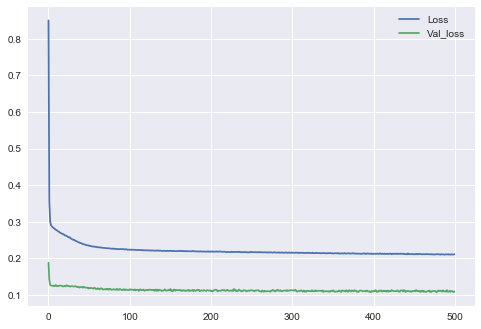

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss'])
plt.show()

In [26]:
predictedTest = model.predict(testx)
ploting = predictedTest*test_std + test_mean 
print(test_set['SeasonalSeries'].values.shape)
ploting = ploting + test_set['SeasonalSeries'].values[1:-2, np.newaxis] + test_set['TrendSeries'].values[1:-2, np.newaxis]
print(test_std, test_mean)
print(test_set['SeasonalSeries'].values.shape, test_set['TrendSeries'].values.shape)
print(predictedTest.shape, ploting.shape)


(262,)
21152.965950535596 -376.251799242418
(262,) (262,)
(259, 1) (259, 1)


In [27]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error for residual series: %.4f'%mean_absolute_error(predictedTest, testy))
print('Mean absolute error for complete series: %.4f'%mean_absolute_error(ploting, test_set['activeEnergy'][1:-2].values))

Mean absolute error for residual series: 0.5149
Mean absolute error for complete series: 10891.2696


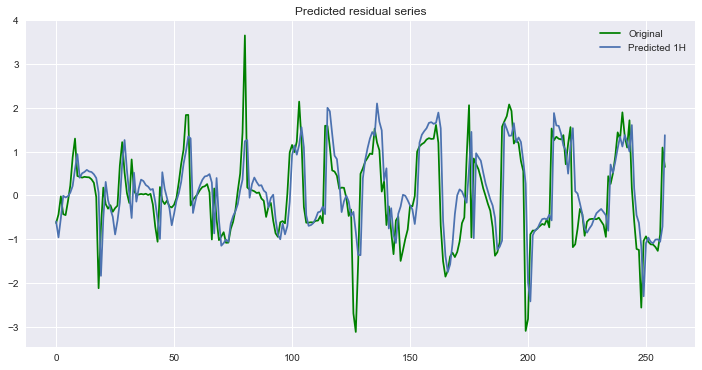

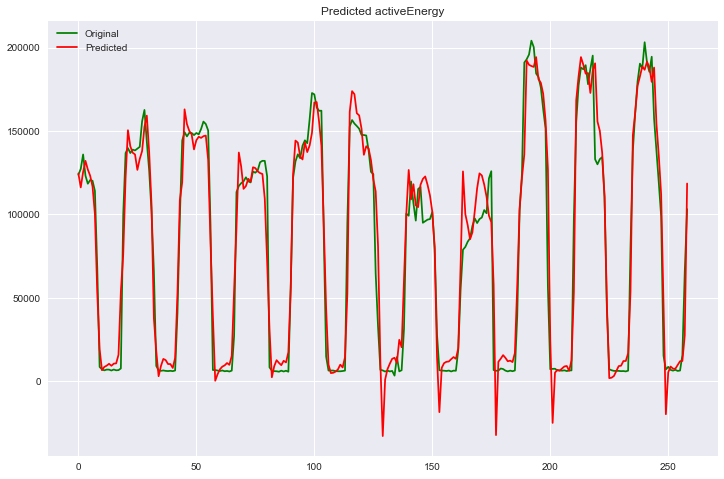

In [28]:
plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
plt.plot(test_set['ResidualSeries'][1:-2].values, 'g')
plt.plot(predictedTest)
plt.legend(['Original', 'Predicted 1H', 'Predicted 2H', 'Predicted 3H'])
plt.show()

plt.figure(figsize = (12,8))
plt.title('Predicted activeEnergy')
plt.plot(test_set['activeEnergy'][1:-2].values, 'g')
plt.plot(ploting, 'r')
plt.legend(['Original', 'Predicted'])

plt.show()

